In [1]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import xgboost as xgb

import string
import re

import unidecode

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist

import pickle

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('csv_files/job_post_dataframe.csv', index_col=0)

In [3]:
# appear to have been nan values, so i dropped the rows with them
df.dropna(subset=['overview'], inplace=True)

In [4]:
# specifying feature and target variables
X = df['overview']
y = df['target']

In [5]:
sns.set(font_scale=1.5, palette='Set1')

# Process to create wordclouds by finding word frequency

In [6]:
# creating regex condition for cleaning punctuation
remove = string.punctuation
remove = remove.replace('/', '') # don't remove hyphens
pattern = r'[{}]'.format(remove)

In [7]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = unidecode.unidecode(text)
    text.replace('\\n', '')
    text.strip(' \\n')
    text = re.sub(pattern, ' ', str(text))
    text = re.sub('(\\*n)', ' ', str(text))
    text = re.sub('\w*\d\w*', ' ', str(text))
    text = re.sub('  ', ' ', str(text))
    return text

In [9]:
clean = lambda x: clean_text(x)

In [10]:
df.overview = df.overview.apply(clean)

In [11]:
df.languages = df.languages.apply(clean)

In [13]:
def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

In [14]:
df.overview = tokenize(df.overview)

In [16]:
df.languages = tokenize(df.languages)

In [17]:
# creating a list of stopwords 
stopwords_list = stopwords.words('english') + list(string.punctuation)

# adding these as stopwords since they are part of a disclaimer that the employer will not prejudice against these, 
# which is a very common message
stopwords_list += ['python-3.x', 'race', 'color', 'ancestry', 'religion', 'national origin', 'sex',
                   'sexual orientation', 'age', 'citizenship', 'marital status', 'disability', 'gender identity', 
                   'gender expression', 'veteran status', 'gender', 'experience', 'financial', 'opportunity', 
                   'people', 'development', 'team', 'work']

df.overview = df['overview'].apply(lambda x: [item for item in x if item not in stopwords_list])
df.languages = df['languages'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [19]:
# creating df for each job classification
python = df[df['target'] == 1].copy()
not_python = df[df['target'] == 0].copy()

In [20]:
# creating list of every word in the overview for each df and a list of every word in languages column
all_overview_python = list(python['overview'])
all_overview_not = list(not_python['overview'])
all_lang_words = list(df['languages'])

###### making sure that only unique words are in the set

In [22]:
unique_overview_python = set()
for word in all_overview_python:
    unique_overview_python.update(word)
len(unique_overview_python)

8079

In [23]:
unique_overview_not = set()
for third in all_overview_not:
    unique_overview_not.update(third)
len(unique_overview_not)

18485

In [24]:
unique_lang_words = set()
for second in all_lang_words:
    unique_lang_words.update(second)
len(unique_lang_words)

706

### checking frequency of each word

###### frequency of words in overview column in the python df

In [25]:
overview_python = [item for sublist in all_overview_python for item in sublist]

In [27]:
python_overview_freq = FreqDist(overview_python)

In [29]:
python_overview_word_count = [x[1] for x in python_overview_freq.most_common(20)]
python_overview_words = [x[0] for x in python_overview_freq.most_common(20)]

In [31]:
python_overview_freq_dict = dict(zip(python_overview_words, python_overview_word_count))

###### frequency of words in overview column in the not_python df

In [26]:
overview_not = [item for sublist in all_overview_not for item in sublist]

In [28]:
not_overview_freq = FreqDist(overview_not)

In [30]:
not_overview_word_count = [x[1] for x in not_overview_freq.most_common(20)]
not_overview_words = [x[0] for x in not_overview_freq.most_common(20)]

In [32]:
not_overview_freq_dict = dict(zip(not_overview_words, not_overview_word_count))

###### frequency of words in languages column in the overall df

In [33]:
lang_words = [item for sublist in all_lang_words for item in sublist]

In [34]:
lang_freq = FreqDist(lang_words)

In [35]:
top_lang_word_count = [x[1] for x in lang_freq.most_common(15)]
top_lang_words = [x[0] for x in lang_freq.most_common(15)]

In [36]:
lang_freq_dict = dict(zip(top_lang_words, top_lang_word_count))

In [37]:
{k: v for k,v in sorted(lang_freq_dict.items(), reverse=True, key=lambda item: item[1])}

{'java': 727,
 'c': 406,
 'python': 380,
 'web': 342,
 'services': 332,
 'spring': 308,
 'javascript': 298,
 'amazon': 259,
 'reactjs': 256,
 'sql': 223,
 'cloud': 192,
 'js': 138,
 'net': 138,
 'design': 138,
 'linux': 116}

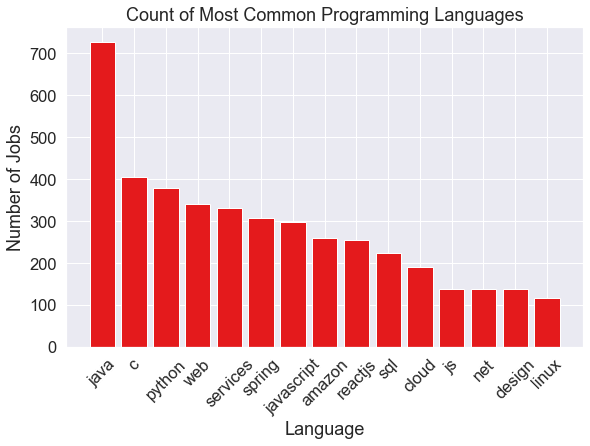

In [38]:
plt.figure(figsize=(8,6))
ax = plt.bar(lang_freq_dict.keys(), lang_freq_dict.values())

plt.title('Count of Most Common Programming Languages')
plt.xlabel('Language')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)

plt.tight_layout(pad=0)
# plt.savefig('images/common_lang.png', dpi=200)
plt.show()

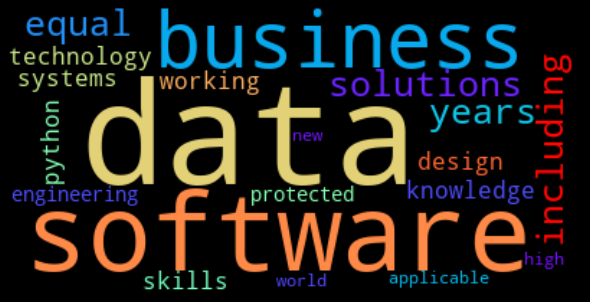

In [58]:
# Create the a word cloud for job overviews with python as a requirement:
wordcloud = WordCloud(background_color='black', colormap='rainbow').generate_from_frequencies(python_overview_freq_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(8,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout(pad=0)
# plt.savefig('images/python_wordcloud.png', dpi=300)

plt.show()

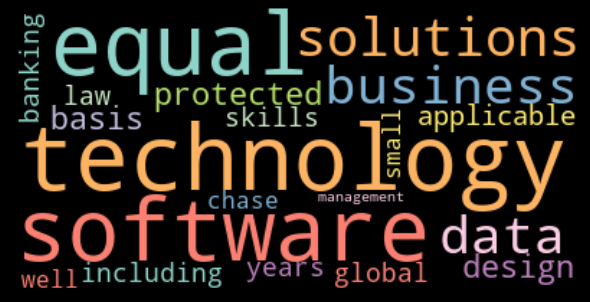

In [57]:
# Create the a word cloud for programming languages:

wordcloud = WordCloud(background_color='black',colormap='Set3_r').generate_from_frequencies(not_overview_freq_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(8,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout(pad=0)
# plt.savefig('images/not_python_wordcloud.png', dpi=300)

plt.show()

# Class Imbalance Plot

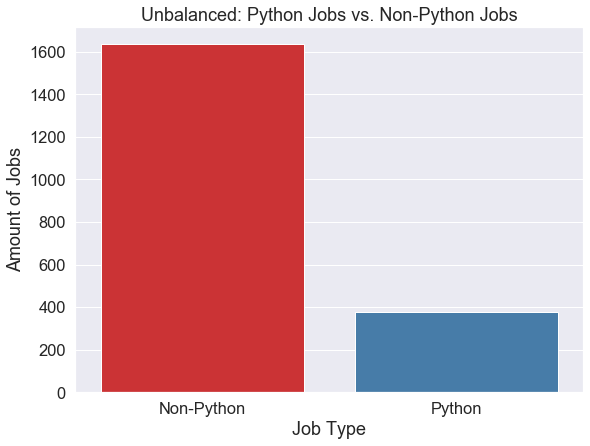

In [47]:
plt.figure(figsize=(8,6))
ax = sns.countplot(df['target'])

plt.title('Unbalanced: Python Jobs vs. Non-Python Jobs')
plt.ylabel('Amount of Jobs')
plt.xlabel('Job Type')
ax.set(xticklabels=['Non-Python', 'Python'])

plt.tight_layout(pad=0)
# plt.savefig('images/class_imbalance.png', dpi=200)
plt.show()

In [37]:
with open('balanced_train', 'rb') as handle:
    y_train_ada = pickle.load(handle)

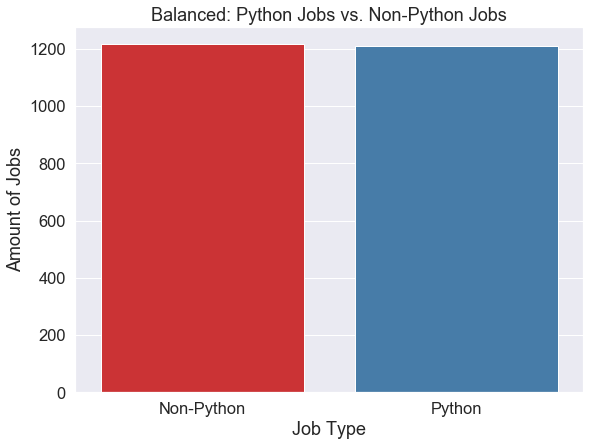

In [46]:
plt.figure(figsize=(8,6))
ax = sns.countplot(y_train_ada)

plt.title('Balanced: Python Jobs vs. Non-Python Jobs')
plt.ylabel('Amount of Jobs')
plt.xlabel('Job Type')
ax.set(xticklabels=['Non-Python', 'Python'])

plt.tight_layout(pad=0)
# plt.savefig('images/balanced_classes.png', dpi=200)
plt.show()

# Creating Feature Importance plot of Random Forest

In [8]:
# # initializing test train split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
# tf = TfidfVectorizer(stop_words = stopwords_list)
    
# tf_idf_train = tf.fit_transform(X_train)
# tf_idf_test = tf.transform(X_test)
    
# # vectorizor = tf.fit(X_train)

In [23]:
# rf_classifier = RandomForestClassifier()
# rf_classifier.fit(tf_idf_train, y_train)

# rf_train_preds = rf_classifier.predict(tf_idf_train)

# rf_test_preds = rf_classifier.predict(tf_idf_test)

In [24]:
# feat_importanceDF_rfc_2 = pd.DataFrame(rf_classifier.feature_importances_, index=tf.vocabulary)
# feat_importanceDF_rfc_2.sort_values(by=0,ascending=False).head(15)

,0
11678,0.052696
3512,0.008984
4246,0.006057
8598,0.004148
8255,0.003999
9243,0.003815
12968,0.003253
5482,0.003093
11773,0.002994
10840,0.002756


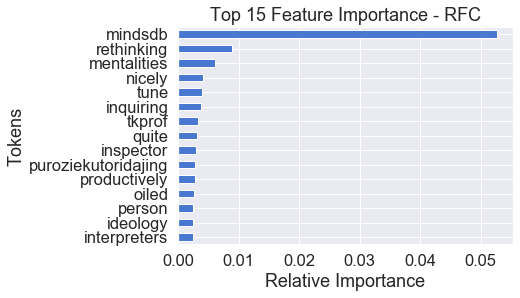

In [27]:
# feat_importances_2 = pd.Series(rf_classifier.feature_importances_,index=tf.vocabulary_)
# feat_importances_2.nlargest(15).sort_values().plot(kind='barh')
# # plt.figure(figsize=(10,10))
# plt.title("Top 15 Feature Importance - RFC")
# plt.xlabel('Relative Importance')
# plt.ylabel('Tokens')
# plt.show()